## Multiple Chronic Conditions Machine Learning Modeling

### Import relevant libraries

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv

### Load MCC Datasets

In [2]:
# Load MCC specific data
mcc_df = pd.read_csv("processed_mcc_data_2017_2018.csv")

### Data Exploration

In [3]:
mcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89952 entries, 0 to 89951
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Bene_Geo_Lvl              89952 non-null  object 
 1   Bene_Geo_Desc             89952 non-null  object 
 2   Bene_Geo_Cd               88992 non-null  float64
 3   Bene_Age_Lvl              89952 non-null  object 
 4   Bene_Demo_Lvl             89952 non-null  object 
 5   Bene_Demo_Desc            89952 non-null  object 
 6   Bene_MCC                  89952 non-null  object 
 7   Prvlnc                    82512 non-null  float64
 8   Tot_Mdcr_Stdzd_Pymt_PC    82484 non-null  float64
 9   Tot_Mdcr_Pymt_PC          82484 non-null  float64
 10  Hosp_Readmsn_Rate         50338 non-null  float64
 11  ER_Visits_Per_1000_Benes  78648 non-null  float64
 12  year                      89952 non-null  int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 8.9+ MB


In [4]:
mcc_df.head()

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_MCC,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes,year
0,State,Alabama,1.0,65+,All,All,0 to 1,0.2318,1999.5660,1806.2546,0.0464,127.2703,2017
1,State,Alabama,1.0,65+,All,All,2 to 3,0.2911,5198.6566,4738.4133,0.0589,307.5730,2017
2,State,Alabama,1.0,65+,All,All,4 to 5,0.2604,9896.6809,9017.2930,0.0936,576.8055,2017
3,State,Alabama,1.0,65+,All,All,6+,0.2168,27177.0547,24715.7787,0.2071,1594.5694,2017
4,State,Alabama,1.0,65+,Dual Status,Medicare Only,0 to 1,0.2473,1982.6565,1790.6022,0.0468,117.0981,2017


### Data Preprocessing

#### Exclude redundant data groups

In [111]:
# Create new year column for 2017 MCC data
mcc_dff = mcc_df[(mcc_df.Bene_Geo_Lvl == 'State') & (mcc_df.Bene_Age_Lvl != 'All') & (mcc_df.Bene_Demo_Desc != 'All') &\
                 (mcc_df.Hosp_Readmsn_Rate.notnull())].reset_index(drop=True)

#### Explore filtered data

In [112]:
mcc_dff.shape

(5858, 13)

In [113]:
mcc_dff.head()

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_MCC,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes,year
0,State,Alabama,1.0,65+,Dual Status,Medicare Only,0 to 1,0.2473,1982.6565,1790.6022,0.0468,117.0981,2017
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,2 to 3,0.3028,5113.1152,4665.4711,0.0586,283.4593,2017
2,State,Alabama,1.0,65+,Dual Status,Medicare Only,4 to 5,0.2578,9650.4733,8806.6521,0.0908,534.1024,2017
3,State,Alabama,1.0,65+,Dual Status,Medicare Only,6+,0.1921,26061.1230,23776.4190,0.2038,1473.4968,2017
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,2 to 3,0.2236,5864.6106,5306.2806,0.0605,495.3020,2017


### Data Preprocesing

#### Feature engineering

In [114]:
mcc_dff['Age_Group'] = np.where(mcc_dff.Bene_Age_Lvl =='<65',0,1)

In [115]:
mcc_dff['Sex'] = np.where(mcc_dff.Bene_Demo_Desc == 'Female',0, np.where(mcc_dff.Bene_Demo_Desc == 'Male',1,-1))

In [116]:
mcc_dff['Medicare_Type'] = np.where(mcc_dff.Bene_Demo_Desc == 'Medicare Only',0, np.where(mcc_dff.Bene_Demo_Desc == 'Medicare and Medicaid',1,-1))

In [117]:
mcc_dff['Non-Hispanic_White'] = np.where(mcc_dff.Bene_Demo_Desc == 'non-Hispanic White',1,
                                np.where(mcc_dff.Bene_Demo_Desc.isin(['Hispanic','non-Hispanic Black','Asian Pacific Islander', 'Native American']),0,-1))

In [118]:
mcc_dff['Non-Hispanic_Black'] = np.where(mcc_dff.Bene_Demo_Desc == 'non-Hispanic Black',1,
                                np.where(mcc_dff.Bene_Demo_Desc.isin(['Hispanic','non-Hispanic White','Asian Pacific Islander', 'Native American']),0,-1))

In [119]:
mcc_dff['Hispanic'] = np.where(mcc_dff.Bene_Demo_Desc == 'Hispanic',1,
                               np.where(mcc_dff.Bene_Demo_Desc.isin(['non-Hispanic White','non-Hispanic Black','Asian Pacific Islander', 'Native American']),0,-1))

In [120]:
mcc_dff['Asian_Pacific_Islander'] = np.where(mcc_dff.Bene_Demo_Desc == 'Asian Pacific Islander',1,
                               np.where(mcc_dff.Bene_Demo_Desc.isin(['non-Hispanic White','non-Hispanic Black','Hispanic', 'Native American']),0,-1))

In [121]:
mcc_dff['Native_American'] = np.where(mcc_dff.Bene_Demo_Desc == 'Native American',1,
                               np.where(mcc_dff.Bene_Demo_Desc.isin(['non-Hispanic White','non-Hispanic Black','Hispanic', 'Asian Pacific Islander']),0,-1))

In [122]:
mcc_dff['MCC_Group'] = np.where(mcc_dff.Bene_MCC == '0 to 1',0, np.where(mcc_dff.Bene_MCC == '2 to 3',1,np.where(mcc_dff.Bene_MCC == '4 to 5',2,3)))

In [123]:
mcc_dff.columns

Index(['Bene_Geo_Lvl', 'Bene_Geo_Desc', 'Bene_Geo_Cd', 'Bene_Age_Lvl',
       'Bene_Demo_Lvl', 'Bene_Demo_Desc', 'Bene_MCC', 'Prvlnc',
       'Tot_Mdcr_Stdzd_Pymt_PC', 'Tot_Mdcr_Pymt_PC', 'Hosp_Readmsn_Rate',
       'ER_Visits_Per_1000_Benes', 'year', 'Age_Group', 'Sex', 'Medicare_Type',
       'Non-Hispanic_White', 'Non-Hispanic_Black', 'Hispanic',
       'Asian_Pacific_Islander', 'Native_American', 'MCC_Group'],
      dtype='object')

In [124]:
ml_cols = ['Year', 'Age_Group', 'Sex', 'Medicare_Type', 'Non-Hispanic_White', 'Non-Hispanic_Black', 'Hispanic',
           'Asian_Pacific_Islander', 'Native_American', 'MCC_Group', 'Hosp_Readmsn_Rate']

In [125]:
mcc_dff[ml_cols[1:]]

,Age_Group,Sex,Medicare_Type,Non-Hispanic_White,Non-Hispanic_Black,Hispanic,Asian_Pacific_Islander,Native_American,MCC_Group,Hosp_Readmsn_Rate
0,1,-1,0,-1,-1,-1,-1,-1,0,0.0468
1,1,-1,0,-1,-1,-1,-1,-1,1,0.0586
2,1,-1,0,-1,-1,-1,-1,-1,2,0.0908
3,1,-1,0,-1,-1,-1,-1,-1,3,0.2038
4,1,-1,1,-1,-1,-1,-1,-1,1,0.0605
...,...,...,...,...,...,...,...,...,...,...
5853,0,-1,-1,0,1,0,0,0,1,0.0000
5854,0,-1,-1,0,1,0,0,0,2,0.0000
5855,0,-1,-1,1,0,0,0,0,1,0.1207
5856,0,-1,-1,1,0,0,0,0,2,0.1359


#### Perform correlation analysis excluding groups with unknown (-1) categories

In [169]:
mcc_corr_df = mcc_dff[mcc_dff != -1][ml_cols[1:]].corr(method='spearman', numeric_only=True).round(2)

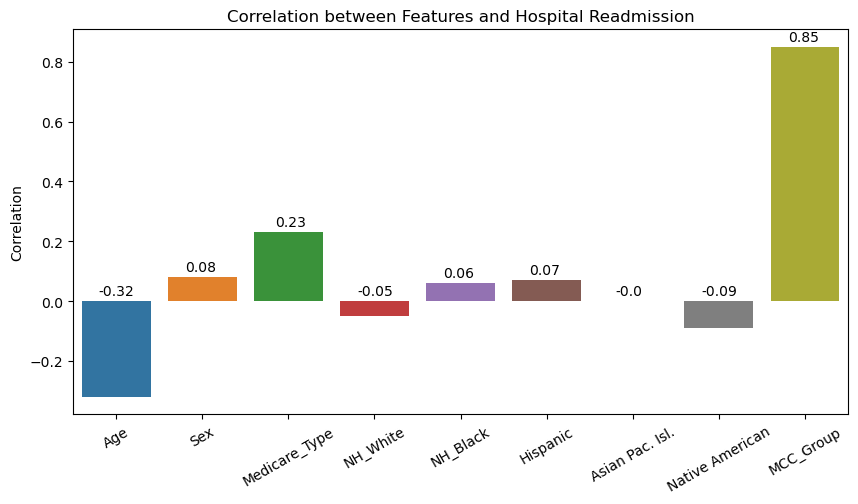

In [174]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x=mcc_corr_df.iloc[-1,:-1].index, y=mcc_corr_df.iloc[-1,:-1]);
ax.set_xticklabels(labels=['Age', 'Sex', 'Medicare_Type', 'NH_White', 'NH_Black', 'Hispanic', 'Asian Pac. Isl.', 'Native American', 'MCC_Group'], rotation=30);
ax.set_ylabel("Correlation")
ax.set_title("Correlation between Features and Hospital Readmission");
plt.text(-0.2,0.02,mcc_corr_df.iloc[-1,:-1].iloc[0]);
plt.text(0.8,mcc_corr_df.iloc[-1,:-1].iloc[1]+0.02,mcc_corr_df.iloc[-1,:-1].iloc[1]);
plt.text(1.85,mcc_corr_df.iloc[-1,:-1].iloc[2]+0.02,mcc_corr_df.iloc[-1,:-1].iloc[2]);
plt.text(2.8,0.02,mcc_corr_df.iloc[-1,:-1].iloc[3]);
plt.text(3.8,mcc_corr_df.iloc[-1,:-1].iloc[4]+0.02,mcc_corr_df.iloc[-1,:-1].iloc[4]);
plt.text(4.8,mcc_corr_df.iloc[-1,:-1].iloc[5]+0.02,mcc_corr_df.iloc[-1,:-1].iloc[5]);
plt.text(5.8,0.02,mcc_corr_df.iloc[-1,:-1].iloc[6]);
plt.text(6.8,0.02,mcc_corr_df.iloc[-1,:-1].iloc[7]);
plt.text(7.8,mcc_corr_df.iloc[-1,:-1].iloc[8]+0.02,mcc_corr_df.iloc[-1,:-1].iloc[8]);

#### Define input features for ML modeling

In [179]:
ml_input_feats = ['Age_Group', 'Sex', 'Medicare_Type', 'Non-Hispanic_White', 'Non-Hispanic_Black', 'Hispanic', 'Native_American', 'MCC_Group']

### Save MCC data processed for ML Modeling

In [180]:
mcc_dff.to_csv("ml_processed_mcc_data_2017_2018.csv", index=False)

In [176]:
mcc_dff['Native_American'].value_counts()

Native_American
-1    3173
 0    2313
 1     372
Name: count, dtype: int64

In [177]:
mcc_dff['Asian_Pacific_Islander'].value_counts()

Asian_Pacific_Islander
-1    3173
 0    2306
 1     379
Name: count, dtype: int64